# Learning rate - Problem 8
## Description

### Average time : 200 minutes

### PDE
We will try to find the best learning rate to the problem 8 of the article: https://ieeexplore.ieee.org/document/712178  

$\Delta \psi(x,y) +\psi(x,y)\cdot\frac{\partial \psi(x,y)}{\partial y}= f(x,y)$ on $\Omega = [0,1]^2$  
where $f(x, y)=\sin(\pi x)(2-\pi^2y^2+2y^3\sin(\pi x))$   

### Boundary conditions    
$\psi(0,y)=\psi(1,y)=\psi(x,0)=0$ and $\frac{\partial \psi}{\partial y}(x,1)=2\sin(\pi x)$           

### Loss function
The loss to minimize here is $\mathcal{L} = ||\Delta \psi(x,y) +\psi(x,y)\cdot\frac{\partial \psi(x,y)}{\partial y}-f(x,y) ||_2$  

### Analytical solution
The true function $\psi$ should be $\psi(x, y)=y^2sin(\pi x)$  
This solution is the same of the problem 7

### Approximated solution
We want find a solution $\psi(x,y)=A(x,y)+F(x,y)N(x,y)$
s.t:  
$F(x,y)=\sin(x-1)\sin(y-1)\sin(x)\sin(y)$ 
$A(x,y)=y\sin(\pi x)$   


# Importing libraries

In [1]:
# Jax libraries
from jax import value_and_grad,vmap,jit,jacfwd
from functools import partial 
from jax import random as jran
from jax.example_libraries import optimizers as jax_opt
from jax.nn import tanh, sigmoid, elu, relu, gelu
from jax.lib import xla_bridge
import jax.numpy as jnp

# Others libraries
from time import time
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
print(xla_bridge.get_backend().platform)

gpu


# Multilayer Perceptron

In [2]:
class MLP:
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure
    """
    
    # Class initialization
    def __init__(self,SEED,layers):
        self.key=jran.PRNGKey(SEED)
        self.keys = jran.split(self.key,len(layers))
        self.layers=layers
        self.params = []

    # Initialize the MLP weigths and bias
    def MLP_create(self):
        for layer in range(0, len(self.layers)-1):
            in_size,out_size=self.layers[layer], self.layers[layer+1]
            std_dev = jnp.sqrt(2/(in_size + out_size ))
            weights=jran.truncated_normal(self.keys[layer], -2, 2, shape=(out_size, in_size), dtype=np.float32)*std_dev
            bias=jran.truncated_normal(self.keys[layer], -1, 1, shape=(out_size, 1), dtype=np.float32).reshape((out_size,))
            self.params.append((weights,bias))
        return self.params
        
    # Evaluate a position XY using the neural network    
    @partial(jit, static_argnums=(0,))    
    def NN_evaluation(self,new_params, inputs):
        for layer in range(0, len(new_params)-1):
            weights, bias = new_params[layer]
            inputs = gelu(jnp.add(jnp.dot(inputs, weights.T), bias))
        weights, bias = new_params[-1]
        output = jnp.dot(inputs, weights.T)+bias
        return output
    
    # Get the key associated with the neural network
    def get_key(self):
        return self.key


# Two dimensional PDE operators

In [3]:
class PDE_operators2d:
    """
        Class with the most common operators used to solve PDEs
    Input:
        A function that we want to compute the respective operator
    """
    
    # Class initialization
    def __init__(self,function):
        self.function=function

    # Compute the two dimensional laplacian
    def laplacian_2d(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @partial(jit)    
        def action(params,x,y):
            u_xx = jacfwd(jacfwd(fun, 1), 1)(params,x,y)
            u_yy = jacfwd(jacfwd(fun, 2), 2)(params,x,y)
            return u_xx + u_yy
        vec_fun = vmap(action, in_axes = (None, 0, 0))
        laplacian = vec_fun(params, inputs[:,0], inputs[:,1])
        return laplacian

    # Compute the partial derivative in x
    @partial(jit, static_argnums=(0,))    
    def du_dx(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @partial(jit)    
        def action(params,x,y):
            u_x = jacfwd(fun, 1)(params,x,y)
            return u_x
        vec_fun = vmap(action, in_axes = (None, 0, 0))
        return vec_fun(params, inputs[:,0], inputs[:,1])

    # Compute the partial derivative in y
    @partial(jit, static_argnums=(0,))    
    def du_dy(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @partial(jit)    
        def action(params,x,y):
            u_y = jacfwd(fun, 2)(params,x,y)
            return u_y
        vec_fun = vmap(action, in_axes = (None, 0, 0))
        return vec_fun(params, inputs[:,0], inputs[:,1])

# Physics Informed Neural Networks

In [4]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks   
    Input:
        The evaluation function of the neural network
    """

    # Class initialization
    def __init__(self,NN_evaluation):
        self.operators=PDE_operators2d(self.solution)
        self.laplacian=self.operators.laplacian_2d
        self.NN_evaluation=NN_evaluation
        self.dsol_dy=self.operators.du_dy

    # Definition of the function A(x,y) mentioned above
    @partial(jit, static_argnums=(0,))    
    def A_function(self,inputX,inputY):
        return jnp.multiply(inputY,jnp.sin(jnp.pi*inputX)).reshape(-1,1)

    # Definition of the function F(x,y) mentioned above   
    @partial(jit, static_argnums=(0,))    
    def F_function(self,inputX,inputY):
        F1=jnp.multiply(jnp.sin(inputX),jnp.sin(inputX-jnp.ones_like(inputX)))
        F2=jnp.multiply(jnp.sin(inputY),jnp.sin(inputY-jnp.ones_like(inputY)))
        return jnp.multiply(F1,F2).reshape((-1,1))

    # Definition of the function f(x,y) mentioned above   
    @partial(jit, static_argnums=(0,))    
    def target_function(self,inputs):
        return jnp.multiply(jnp.sin(jnp.pi*inputs[:,0]),2-jnp.pi**2*inputs[:,1]**2+2*inputs[:,1]**3*jnp.sin(jnp.pi*inputs[:,0])).reshape(-1,1) 

    # Compute the solution of the PDE on the points (x,y)
    @partial(jit, static_argnums=(0,))    
    def solution(self,params,inputX,inputY):
        inputs=jnp.column_stack((inputX,inputY))
        NN = vmap(partial(jit(self.NN_evaluation), params))(inputs)
        F=self.F_function(inputX,inputY)
        A=self.A_function(inputX,inputY)
        return jnp.add(jnp.multiply(F,NN),A).reshape(-1,1)

    # Compute the loss function
    @partial(jit, static_argnums=(0,))    
    def loss_function(self,params,batch):
        targets=self.target_function(batch)
        laplacian=self.laplacian(params,batch).reshape(-1,1)
        dsol_dy_values=self.dsol_dy(params,batch)[:,0].reshape((-1,1))
        preds=laplacian+jnp.multiply(self.solution(params,batch[:,0],batch[:,1]),dsol_dy_values).reshape(-1,1)
        return jnp.linalg.norm(preds-targets)
 
    # Train step
    @partial(jit, static_argnums=(0,))    
    def train_step(self,i, opt_state, inputs):
        params = get_params(opt_state)
        loss, gradient = value_and_grad(self.loss_function)(params,inputs)
        return loss, opt_update(i, gradient, opt_state)

# Initialize neural network

In [5]:
# Neural network parameters
SEED = 351
n_features, n_targets = 2, 1            # Input and output dimension
layers = [n_features,30,n_targets]      # Layers structure

# Initialization
NN_MLP=MLP(SEED,layers)                 
params = NN_MLP.MLP_create()            # Create the MLP
NN_eval=NN_MLP.NN_evaluation            # Evaluate function
solver=PINN(NN_eval)
key=NN_MLP.get_key()

# Train parameters

In [6]:
batch_size = 50
num_batches = 100000
report_steps=1000

# Learning rate

In [4]:
init, end, interval_lenght = 0, 6, 25
# Learning rate values
intervals = jnp.array([jnp.linspace(10**(-i),10**(-i)/interval_lenght,interval_lenght) for i in range(init,end)])
learning_rate = jnp.unique(jnp.sort(intervals.reshape(-1,1)[:,0]))
print(len(learning_rate))
print(learning_rate)

147
[4.0000000e-07 7.9999961e-07 1.1999998e-06 1.6000000e-06 1.9999995e-06
 2.3999999e-06 2.7999999e-06 3.1999996e-06 3.5999997e-06 4.0000000e-06
 4.3999994e-06 4.7999997e-06 5.2000000e-06 5.5999994e-06 5.9999998e-06
 6.3999996e-06 6.7999995e-06 7.1999998e-06 7.5999997e-06 7.9999954e-06
 7.9999991e-06 8.3999994e-06 8.7999997e-06 9.2000000e-06 9.5999994e-06
 9.9999997e-06 1.1999997e-05 1.6000000e-05 1.9999994e-05 2.3999997e-05
 2.7999999e-05 3.1999996e-05 3.5999998e-05 3.9999999e-05 4.3999997e-05
 4.7999998e-05 5.1999999e-05 5.5999993e-05 5.9999998e-05 6.3999993e-05
 6.7999994e-05 7.1999995e-05 7.5999997e-05 7.9999962e-05 7.9999991e-05
 8.3999999e-05 8.7999993e-05 9.2000002e-05 9.5999989e-05 9.9999997e-05
 1.1999998e-04 1.6000001e-04 1.9999997e-04 2.3999999e-04 2.8000001e-04
 3.1999996e-04 3.6000001e-04 3.9999999e-04 4.3999997e-04 4.7999999e-04
 5.2000000e-04 5.5999996e-04 5.9999997e-04 6.4000004e-04 6.8000000e-04
 7.2000001e-04 7.6000002e-04 7.9999957e-04 8.0000004e-04 8.3999999e-04
 8

# Solving PDE

In [8]:
# Main loop find the best learning rate
counter=0
min_index=jnp.inf
min_loss_value = jnp.inf
minimum_loss=[]

# Create a file to save the learning rate
file_data_learn=open('./learning_rate','w')
file_data_learn.close()

# Create a file to save the last value of the loss function
file_data_loss=open('./loss_function','w')
file_data_loss.close()

for i in range(len(learning_rate)):
    loss_history = []
    opt_init, opt_update, get_params = jax_opt.adam(learning_rate[i])

    NN_MLP=MLP(SEED,layers)                 
    params = NN_MLP.MLP_create()            # Create the MLP
    NN_eval=NN_MLP.NN_evaluation            # Evaluate function
    solver=PINN(NN_eval)                    # Use PINN on the problem 8
    key=NN_MLP.get_key()                    # Get the key of NN

    opt_state = opt_init(params)            # Initialize opt_state
    
    for ibatch in range(0,num_batches):
        ran_key, batch_key = jran.split(key)
        XY_train = jran.uniform(batch_key, shape=(batch_size, n_features), minval=0, maxval=1)

        loss, opt_state = solver.train_step(ibatch,opt_state, XY_train)
        loss_history.append(float(loss))

        #if ibatch%report_steps==report_steps-1:
            #print("Epoch n°{}: ".format(ibatch+1), loss.item())

    print("iteration",i+1,"of",len(learning_rate))
    print("loss =",loss_history[num_batches-1],"learning rate =",learning_rate[i])
    minimum_loss.append(loss_history[num_batches-1])

    # Get the index for the best learning rate
    if loss_history[num_batches-1]<min_loss_value:
        min_loss_value = loss_history[num_batches-1]
        min_index=i
        print('minimum value =',minimum_loss[i])

    # Save the learning rate
    file_data_learn=open('./learning_rate','a')
    file_data_learn.write(str(learning_rate[i])+',')
    file_data_learn.close()

    # Save the last value of the loss function
    file_data_loss=open('./loss_function','a')
    file_data_loss.write(str(loss_history[num_batches-1])+',')
    file_data_loss.close()

iteration 1 of 99
loss = 0.0056283138692379 learning rate = 9.599999e-05
minimum value = 0.0056283138692379
iteration 2 of 99
loss = 0.0048086014576256275 learning rate = 1e-04
minimum value = 0.0048086014576256275
iteration 3 of 99
loss = 0.00437261164188385 learning rate = 0.00011999998
minimum value = 0.00437261164188385
iteration 4 of 99
loss = 0.00505151366814971 learning rate = 0.00016000001
iteration 5 of 99
loss = 0.0052724299021065235 learning rate = 0.00019999997
iteration 6 of 99
loss = 0.005549023859202862 learning rate = 0.00024
iteration 7 of 99
loss = 0.005764973349869251 learning rate = 0.00028
iteration 8 of 99
loss = 0.005953838117420673 learning rate = 0.00031999996
iteration 9 of 99
loss = 0.006143741775304079 learning rate = 0.00036
iteration 10 of 99
loss = 0.006300668697804213 learning rate = 0.0004
iteration 11 of 99
loss = 0.0064275446347892284 learning rate = 0.00043999997
iteration 12 of 99
loss = 0.0065496391616761684 learning rate = 0.00048
iteration 13 of 

# Plot learning rate optimization

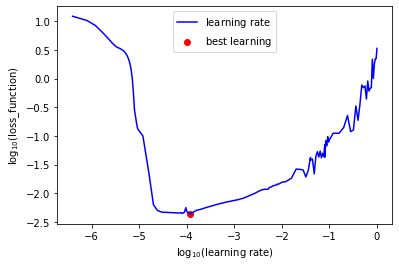

best learning rate = 0.00011999998 
loss = 0.00437261164188385


In [2]:
min_index=50
learning_rate=[4e-07,7.999996e-07,1.1999998e-06,1.6e-06,1.9999995e-06,2.3999999e-06,2.8e-06,3.1999996e-06,3.5999997e-06,4e-06,4.3999994e-06,4.7999997e-06,5.2e-06,5.5999994e-06,5.9999998e-06,6.3999996e-06,6.7999995e-06,7.2e-06,7.5999997e-06,7.999995e-06,7.999999e-06,8.399999e-06,8.8e-06,9.2e-06,9.599999e-06,1e-05,1.1999997e-05,1.6e-05,1.9999994e-05,2.3999997e-05,2.7999999e-05,3.1999996e-05,3.5999998e-05,4e-05,4.3999997e-05,4.7999998e-05,5.2e-05,5.5999993e-05,6e-05,6.399999e-05,6.7999994e-05,7.1999995e-05,7.6e-05,7.999996e-05,7.999999e-05,8.4e-05,8.799999e-05,9.2e-05,9.599999e-05,1e-04,0.00011999998,0.00016000001,0.00019999997,0.00024,0.00028,0.00031999996,0.00036,0.0004,0.00043999997,0.00048,0.00052,0.00055999996,0.00059999997,0.00064000004,0.00068,0.00072,0.00076,0.0007999996,0.00080000004,0.00084,0.00088,0.0009200001,0.00096000003,0.001,0.0011999998,0.0016,0.0019999996,0.0023999996,0.0028,0.0031999995,0.0035999997,0.0039999997,0.004,0.0043999995,0.0047999998,0.0052,0.0055999993,0.0059999996,0.0064,0.006799999,0.0072,0.0075999997,0.007999997,0.0079999985,0.0084,0.0088,0.009199999,0.0095999995,0.01,0.011999999,0.016,0.019999998,0.023999998,0.028,0.031999998,0.036,0.04,0.040000003,0.043999996,0.047999997,0.052,0.055999998,0.06,0.064,0.067999996,0.072,0.076000005,0.07999996,0.08,0.084,0.088,0.092,0.096,0.1,0.11999998,0.16,0.19999996,0.23999998,0.28,0.31999996,0.35999998,0.4,0.43999997,0.48,0.52,0.55999994,0.59999996,0.64,0.67999995,0.71999997,0.76,0.79999995,0.84,0.88,0.92,0.96,1.0]
minimum_loss = [12.199068069458008,10.287569999694824,8.428057670593262,6.696137428283691,5.538702964782715,4.687373161315918,4.059501647949219,3.656656265258789,3.457155704498291,3.325516700744629,3.174725294113159,2.993105411529541,2.772662401199341,2.507611036300659,2.195760726928711,1.8345900774002075,1.426107406616211,0.9818812012672424,0.5550472140312195,0.2830400764942169,0.2830425798892975,0.21830421686172485,0.17070499062538147,0.13883444666862488,0.12758783996105194,0.12315638363361359,0.10009343922138214,0.022998584434390068,0.006351709831506014,0.005078324116766453,0.004771950654685497,0.004673386458307505,0.004661232698708773,0.004636757075786591,0.004623145796358585,0.004604278597980738,0.0045907096937298775,0.004563584458082914,0.004564367700368166,0.004526973236352205,0.004533765837550163,0.004557443782687187,0.004603053443133831,0.00447818823158741,0.004484650678932667,0.004502951167523861,0.004616164602339268,0.00500076450407505,0.0056283138692379,0.0048086014576256275,0.00437261164188385,0.00505151366814971,0.0052724299021065235,0.005549023859202862,0.005764973349869251,0.005953838117420673,0.006143741775304079,0.006300668697804213,0.0064275446347892284,0.0065496391616761684,0.006680157035589218,0.006793366279453039,0.006896598730236292,0.0069457595236599445,0.007037411909550428,0.007094191387295723,0.00715602608397603,0.007218529935926199,0.007215419318526983,0.007279032841324806,0.00733697647228837,0.007450229488313198,0.007429111283272505,0.007506238296627998,0.007746902294456959,0.008289686404168606,0.008984302170574665,0.009617257863283157,0.01011795923113823,0.0107788797467947,0.011304347775876522,0.0116304662078619,0.011619005352258682,0.011790497228503227,0.011702973395586014,0.011884546838700771,0.012837653048336506,0.012833688408136368,0.013390054926276207,0.013657047413289547,0.013788939453661442,0.013915683142840862,0.014332626946270466,0.014518260024487972,0.014350385405123234,0.014661336317658424,0.015009942464530468,0.015280765481293201,0.015574362128973007,0.015930278226733208,0.018411044031381607,0.02647589147090912,0.026135995984077454,0.02557310089468956,0.01927211880683899,0.025239434093236923,0.042144015431404114,0.03771758824586868,0.03965884819626808,0.02181864343583584,0.04423406347632408,0.05317981541156769,0.042907778173685074,0.05452097952365875,0.04155665636062622,0.04972462356090546,0.04367397353053093,0.07090074568986893,0.042590875178575516,0.08229882270097733,0.06757473945617676,0.09713171422481537,0.07808905094861984,0.08564911037683487,0.11132657527923584,0.11153824627399445,0.14020493626594543,0.22732415795326233,0.11888231337070465,0.12719812989234924,0.33327990770339966,0.18740606307983398,0.36471953988075256,0.7714767456054688,0.6909691095352173,0.7433273196220398,0.439883828163147,0.9097825288772583,0.6054460406303406,0.6783227920532227,0.6899469494819641,2.1728146076202393,1.0038481950759888,1.763105869293213,2.2033491134643555,2.211721897125244,3.3589024543762207]
fig, ax = plt.subplots(1, 1)
__=ax.plot(np.log10(learning_rate),np.log10(minimum_loss),color='blue')
__=ax.scatter(np.log10(learning_rate[min_index]),np.log10(minimum_loss[min_index]),color='red')
legend = ax.legend([r'${\rm learning \ rate}$',r'${\rm best \ learning }$'])
xlabel = ax.set_xlabel(r'$\log_{10}{\rm (learning \ rate)}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm (loss\_function)}$')
#title = ax.set_title(r'${\rm Learning \ rate \ optimization}$')
plt.show()
print("best learning rate =",learning_rate[min_index],"\nloss =",minimum_loss[min_index])